In [2]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import keras
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10
                                 ) 
plt.rcParams['axes.grid']=False
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

/home/bilbo/dev/cenv/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/tmp/ipykernel_15356/1794828178.py:2: FutureWarning: Pass y=[0.         0.         0.         ... 0.0026426  0.00241061 0.00199798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  dur_time = librosa.get_duration(y,sr=sr)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

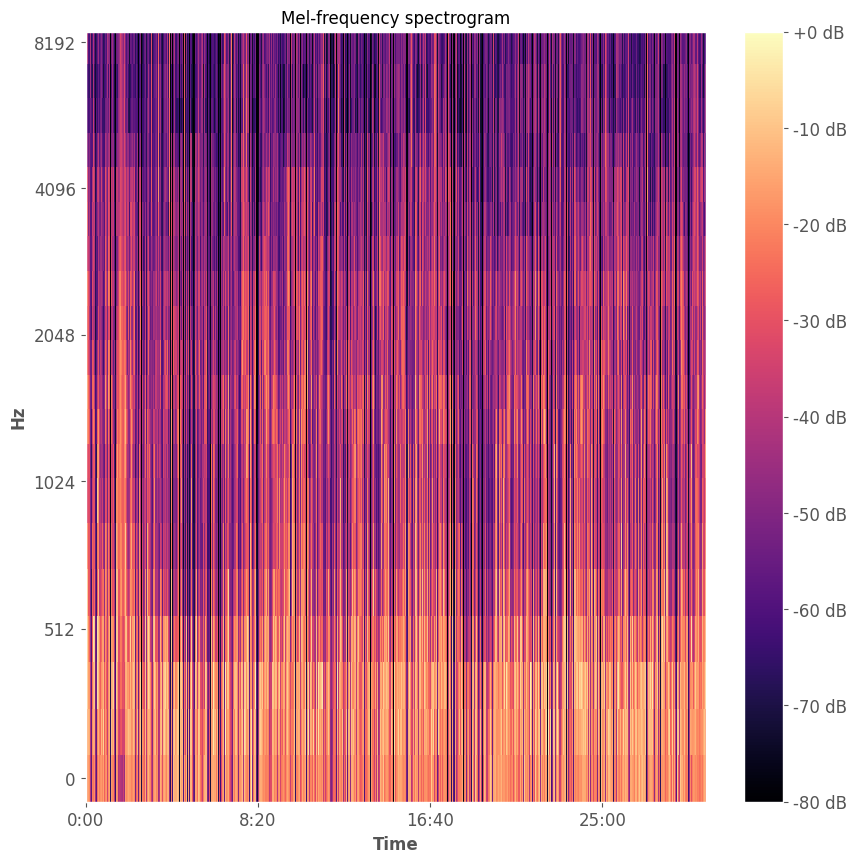

In [4]:
y,sr = librosa.load('trimmed.mp3')
dur_time = librosa.get_duration(y,sr=sr)
time_sec = round(dur_time)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
#plt.xlim(60,120)

In [5]:
start = 0 
end = time_sec 
time_series_sec = np.linspace(start,end,len(S_dB[0]))

In [6]:
data = pd.read_csv('archive/us_election_2020_1st_presidential_debate.csv')

In [7]:
def convert_to_sec(time_string):
    time_s_list = time_string.split(':')
    if len(time_s_list)>2:
        date_time = datetime.datetime.strptime(time_string, "%H:%M:%S")
        a_timedelta = date_time - datetime.datetime(1900, 1, 1)
        seconds = a_timedelta.total_seconds()
    else:
        date_time = datetime.datetime.strptime(time_string, "%M:%S")
        a_timedelta = date_time - datetime.datetime(1900, 1, 1)
        seconds = a_timedelta.total_seconds()
    return seconds

In [8]:
minute_list = data.minute.tolist()

In [9]:
SEC_LIST = []
for t in minute_list:
    try:
        SEC_LIST.append(convert_to_sec(t))
    except:
        SEC_LIST.append(0)
for k in range(2):
    for i in range(len(SEC_LIST)-1):
        if SEC_LIST[i]==SEC_LIST[i+1]:
            SEC_LIST[i+1]=SEC_LIST[i]+1
turn_index = SEC_LIST.index(0)
to_add = SEC_LIST[turn_index-1]
for j in range(turn_index,len(SEC_LIST)):
    SEC_LIST[j]=SEC_LIST[j]+to_add
data['Seconds']=SEC_LIST

In [10]:
data.head()

speaker minute  \
0              Chris Wallace  01:20   
1              Chris Wallace  02:10   
2   Vice President Joe Biden  02:49   
3  President Donald J. Trump  02:51   
4   Vice President Joe Biden  02:51   

                                                text  Seconds  
0  Good evening from the Health Education Campus ...     80.0  
1  This debate is being conducted under health an...    130.0  
2                                How you doing, man?    169.0  
3                                 How are you doing?    171.0  
4                                          I’m well.    172.0

In [11]:
new_data = data[data.Seconds<=time_series_sec.max()]
new_data.speaker = new_data.speaker.replace({'Chris Wallace:':'Chris Wallace'})

/tmp/ipykernel_15356/4195345583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.speaker = new_data.speaker.replace({'Chris Wallace:':'Chris Wallace'})


In [12]:
max_sec = new_data.Seconds.max()

In [13]:
new_data.drop_duplicates(subset='speaker')

speaker minute  \
0              Chris Wallace  01:20   
2   Vice President Joe Biden  02:49   
3  President Donald J. Trump  02:51   

                                                text  Seconds  
0  Good evening from the Health Education Campus ...     80.0  
2                                How you doing, man?    169.0  
3                                 How are you doing?    171.0

/home/bilbo/dev/cenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


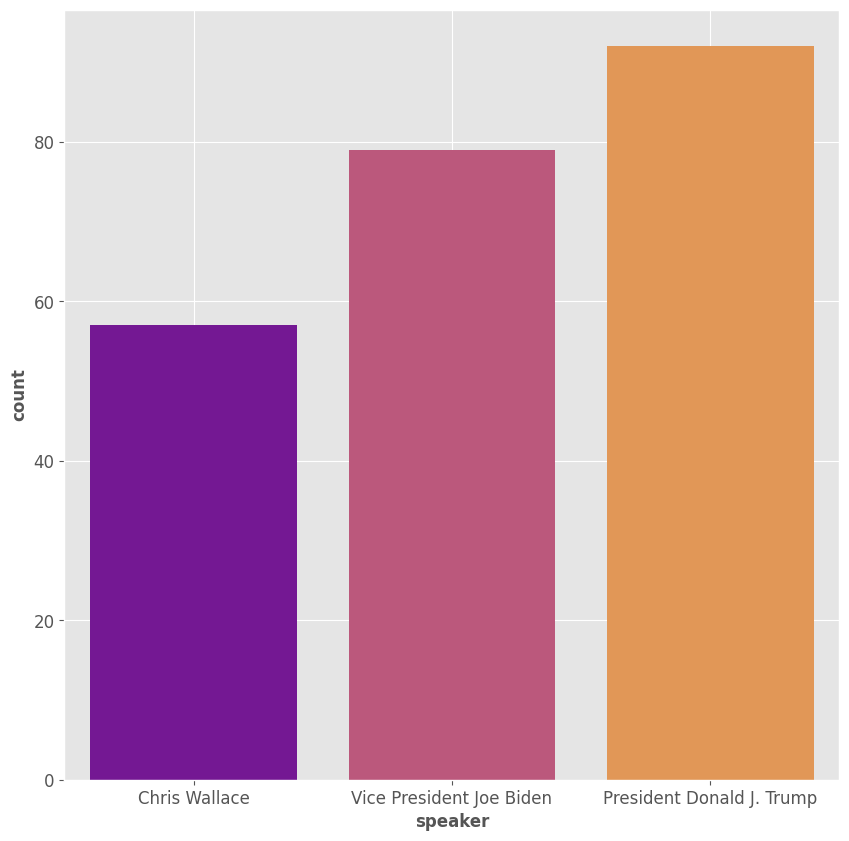

In [14]:
sns.countplot(new_data.speaker,palette='plasma')
plt.grid(True)

In [15]:
audio_data = pd.DataFrame(S_dB)

In [16]:
audio_data = audio_data.T
audio_data.tail()

0          1          2          3          4          5   \
77515 -16.055141 -15.316716  -4.683353 -15.229792 -21.680511 -24.810167   
77516 -18.239595 -16.750111  -8.486637 -13.513140 -16.484486 -23.002621   
77517 -18.093203 -15.508173 -12.187483 -14.392996 -18.770016 -28.001715   
77518 -22.523027 -20.450369 -19.081335 -23.318630 -30.644508 -40.129280   
77519 -31.494070 -31.541821 -34.379391 -44.179192 -49.818233 -52.133091   

              6          7          8          9          10         11  \
77515 -26.135960 -24.262783 -27.791191 -40.695381 -41.969879 -42.276779   
77516 -26.490614 -19.890699 -21.016573 -35.113068 -39.562805 -41.936462   
77517 -27.713215 -20.022633 -21.241507 -33.687862 -40.688633 -42.296829   
77518 -36.812347 -29.374660 -29.432180 -41.431076 -50.044815 -48.965546   
77519 -55.072060 -51.321064 -49.415344 -60.716045 -59.336044 -61.997589   

              12         13         14         15         16         17  \
77515 -39.339241 -39.175056 -46.243862 -53.754307 -56.138115 -51.190506   
77516 -34.658768 -35.930069 -47.685917 -49.796745 -54.551399 -44.796970   
77517 -32.801868 -36.371914 -48.471130 -49.078331 -54.025681 -43.626568   
77518 -39.469181 -44.503807 -54.451286 -55.692314 -59.228050 -50.280632   
77519 -63.114052 -65.873161 -69.131378 -68.879692 -72.110825 -68.347038   

              18         19  
77515 -52.874268 -62.661068  
77516 -45.566788 -57.615932  
77517 -44.004204 -56.123360  
77518 -50.638184 -61.930988  
77519 -68.487656 -70.963013

In [17]:
import numpy as np
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=4)
pca.fit(audio_data)

PCA(n_components=4)

In [19]:
pca_data = pd.DataFrame(pca.transform(audio_data))

Text(0, 0.5, 'Second component')

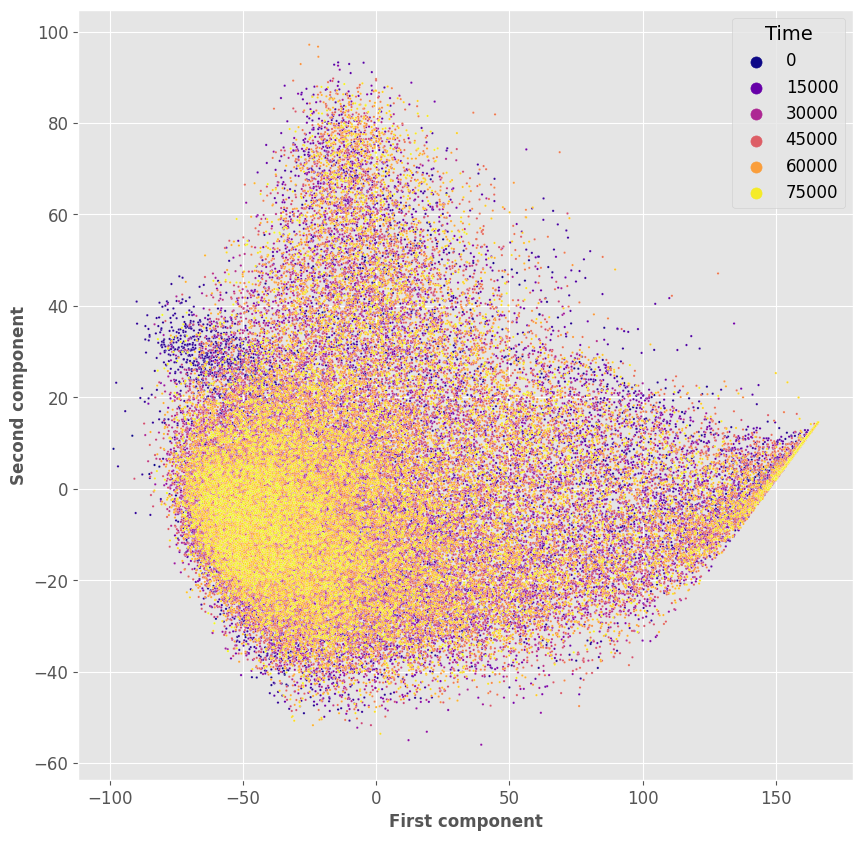

In [20]:
plt.grid(True)
sns.scatterplot(x=pca_data[0],y=pca_data[1],hue=pca_data.index,s=3,palette='plasma')
plt.legend(title='Time')
plt.xlabel('First component')
plt.ylabel('Second component')

In [21]:
audio_time = np.array(pca_data.index.tolist())*max_sec/np.array(pca_data.index.tolist()).max()
pca_data['Time']=audio_time
pca_data.head()

0         1          2         3      Time
0  159.866241  9.908539  14.552564 -2.089700  0.000000
1  145.825699  1.504642  10.557358 -0.596029  0.022975
2  145.349762  1.797760   9.051671 -0.888006  0.045950
3  146.850174  3.645294   8.798366 -0.646026  0.068925
4  143.764313  4.237113  13.075960 -4.097668  0.091900

In [23]:
nd_time_list = [0]+new_data.Seconds.tolist()
CLASS = []
for j in range(len(audio_time)):
    time_j = audio_time[j]
    for i in range(1,len(nd_time_list)):
        start_i = nd_time_list[i-1]
        end_i = nd_time_list[i]
        if time_j>start_i and time_j<end_i:
            CLASS.append(new_data.loc[i-1].speaker)

In [24]:
pca_data['speaker']=CLASS[0:len(pca_data)]

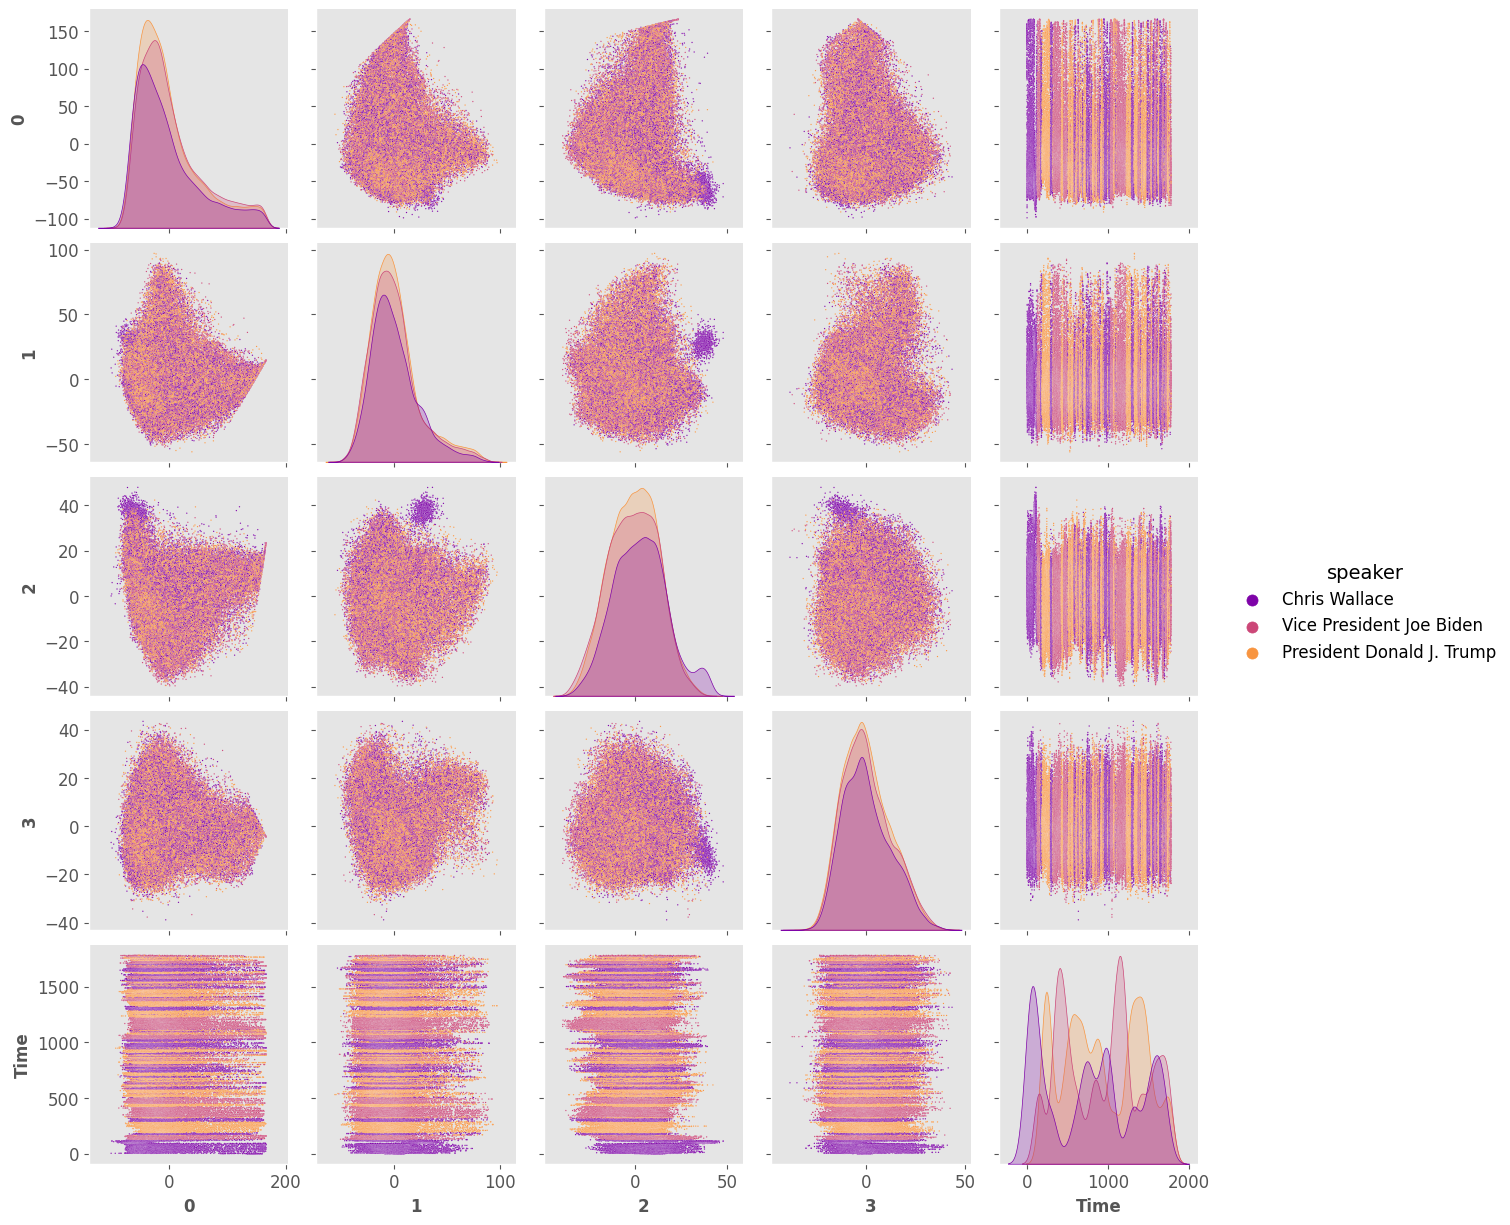

In [25]:
#plt.grid(True)
sns.pairplot(pca_data,hue='speaker',plot_kws={'s':1},palette='plasma')

In [26]:
from sklearn.feature_selection import mutual_info_classif as mi

In [27]:
mi(X=pca_data[['Time',0,1,2,3]],y=pca_data['speaker'])

array([1.08844697, 0.00470393, 0.        , 0.01322602, 0.00198212])

In [28]:
time_series_data = pca_data[['Time',2,'speaker']]

In [29]:
time_series_data = time_series_data.rename(columns={2:'X'})

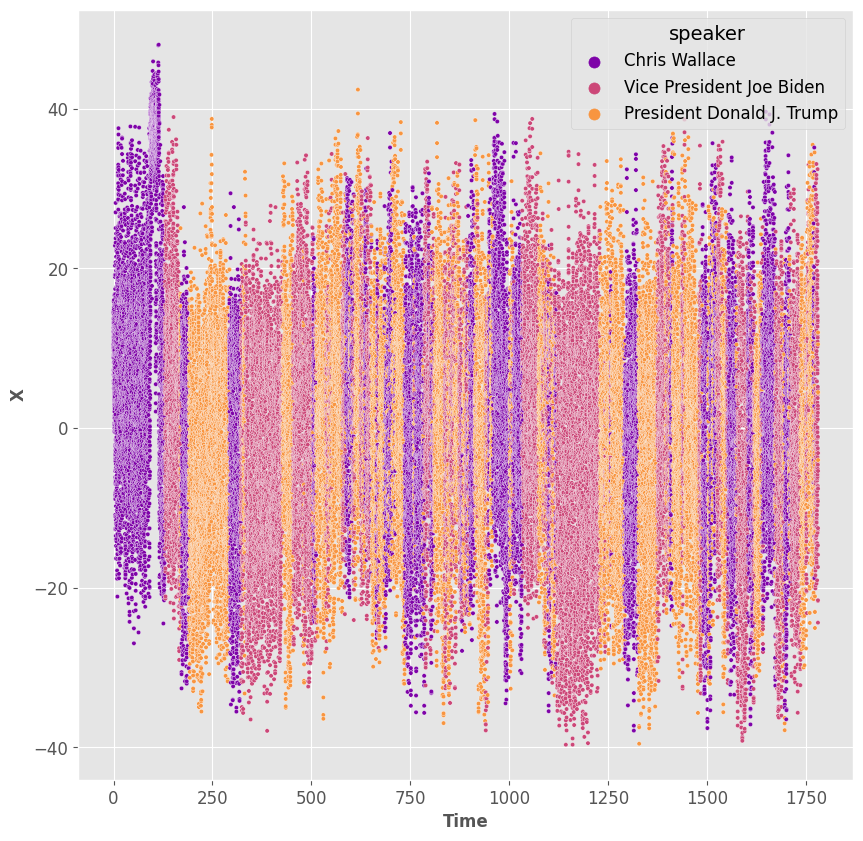

In [30]:
sns.scatterplot(x='Time',y='X',hue='speaker',data=time_series_data,s=10,palette='plasma')
plt.grid(True)

In [35]:
le = LabelEncoder()

In [36]:
time_series_data['speaker']=le.fit_transform(time_series_data.speaker)

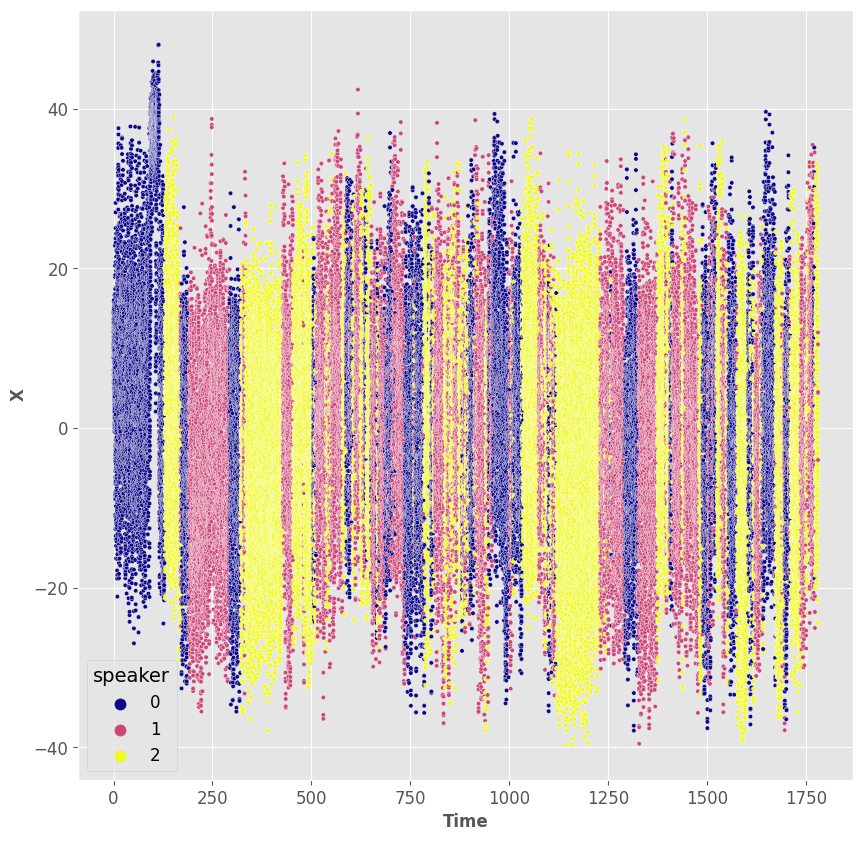

In [38]:
sns.scatterplot(x='Time',y='X',hue='speaker',data=time_series_data,s=10,palette='plasma')
plt.grid(True)

In [39]:
encod_dic = {0:'Chris Wallace',2:'Vice President Joe Biden',1:'President Donald J. Trump'}


In [40]:
X=time_series_data[['Time','X']]
y=time_series_data.speaker

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [42]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [43]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [44]:
num_classes = len(np.unique(y_train))

In [45]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [46]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [47]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)

2022-08-29 17:34:47.511168: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-29 17:34:47.511308: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist


In [49]:
epochs = 30
batch_size = 50

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/30
993/993 [==============================] - 8s 7ms/step - loss: 0.7828 - sparse_categorical_accuracy: 0.6303 - val_loss: 0.7223 - val_sparse_categorical_accuracy: 0.6808 - lr: 0.0010
Epoch 2/30
993/993 [==============================] - 7s 7ms/step - loss: 0.7795 - sparse_categorical_accuracy: 0.6311 - val_loss: 0.7320 - val_sparse_categorical_accuracy: 0.6708 - lr: 0.0010
Epoch 3/30
993/993 [==============================] - 7s 7ms/step - loss: 0.7822 - sparse_categorical_accuracy: 0.6274 - val_loss: 0.7591 - val_sparse_categorical_accuracy: 0.6531 - lr: 0.0010
Epoch 4/30
993/993 [==============================] - 6s 6ms/step - loss: 0.7815 - sparse_categorical_accuracy: 0.6280 - val_loss: 0.7442 - val_sparse_categorical_accuracy: 0.6529 - lr: 0.0010
Epoch 5/30
993/993 [==============================] - 5s 5ms/step - loss: 0.7833 - sparse_categorical_accuracy: 0.6281 - val_loss: 0.7363 - val_sparse_categorical_accuracy: 0.6703 - lr: 0.0010
Epoch 6/30
993/993 [===============

In [50]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

485/485 [==============================] - 1s 3ms/step - loss: 0.7401 - sparse_categorical_accuracy: 0.6585
Test accuracy 0.6584752202033997
Test loss 0.7401024699211121


In [51]:
encod_dic[0]

'Chris Wallace'

In [52]:
pred_test = pd.DataFrame(model.predict(x_test))

485/485 [==============================] - 1s 2ms/step


In [53]:
pred_test = pred_test.rename(columns={0:encod_dic[0]})

In [54]:
pred_test = pred_test.rename(columns={1:encod_dic[1]})

In [55]:
pred_test = pred_test.rename(columns={2:encod_dic[2]})

In [56]:
pred_test.head()

Chris Wallace  President Donald J. Trump  Vice President Joe Biden
0       0.572132                   0.255352                  0.172516
1       0.194541                   0.551710                  0.253750
2       0.001669                   0.014883                  0.983448
3       0.672430                   0.220394                  0.107176
4       0.333818                   0.221022                  0.445160

In [57]:
test_data = X_test.reset_index().drop('index',axis=1)
test_data['target']=y_test
test_data['Chris Wallace']=pred_test['Chris Wallace']
test_data['President Donald J. Trump']=pred_test['President Donald J. Trump']
test_data['Vice President Joe Biden']=pred_test['Vice President Joe Biden']

In [58]:
target_list = test_data.target.tolist()
for t in range(len(target_list)):
    target_list[t]=encod_dic[target_list[t]]

In [59]:
test_data['target']=target_list

In [60]:
test_data = test_data.sort_values(by='Time')

In [61]:
test_data


Time          X                    target  Chris Wallace  \
14289     0.137850  12.016685             Chris Wallace       0.999804   
7997      0.804125  15.849327             Chris Wallace       0.999804   
5710      0.896025   6.703298             Chris Wallace       0.999798   
14057     1.240651  10.215455             Chris Wallace       0.999799   
14010     1.608251   9.075826             Chris Wallace       0.999798   
...            ...        ...                       ...            ...   
9859   1779.851249  13.568225  Vice President Joe Biden       0.200792   
8318   1779.989099   4.867696  Vice President Joe Biden       0.162460   
4181   1780.195875  14.076301  Vice President Joe Biden       0.200720   
2288   1780.218850  13.465536  Vice President Joe Biden       0.197875   
11545  1780.793225 -15.870677  Vice President Joe Biden       0.086263   

       President Donald J. Trump  Vice President Joe Biden  
14289                   0.000008                  0.000189  
7997                    0.000009                  0.000188  
5710                    0.000007                  0.000195  
14057                   0.000007                  0.000193  
14010                   0.000007                  0.000195  
...                          ...                       ...  
9859                    0.367615                  0.431594  
8318                    0.384924                  0.452616  
4181                    0.368925                  0.430355  
2288                    0.369763                  0.432362  
11545                   0.409835                  0.503901  

[15504 rows x 6 columns]

/home/bilbo/dev/cenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/bilbo/dev/cenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/bilbo/dev/cenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/hom

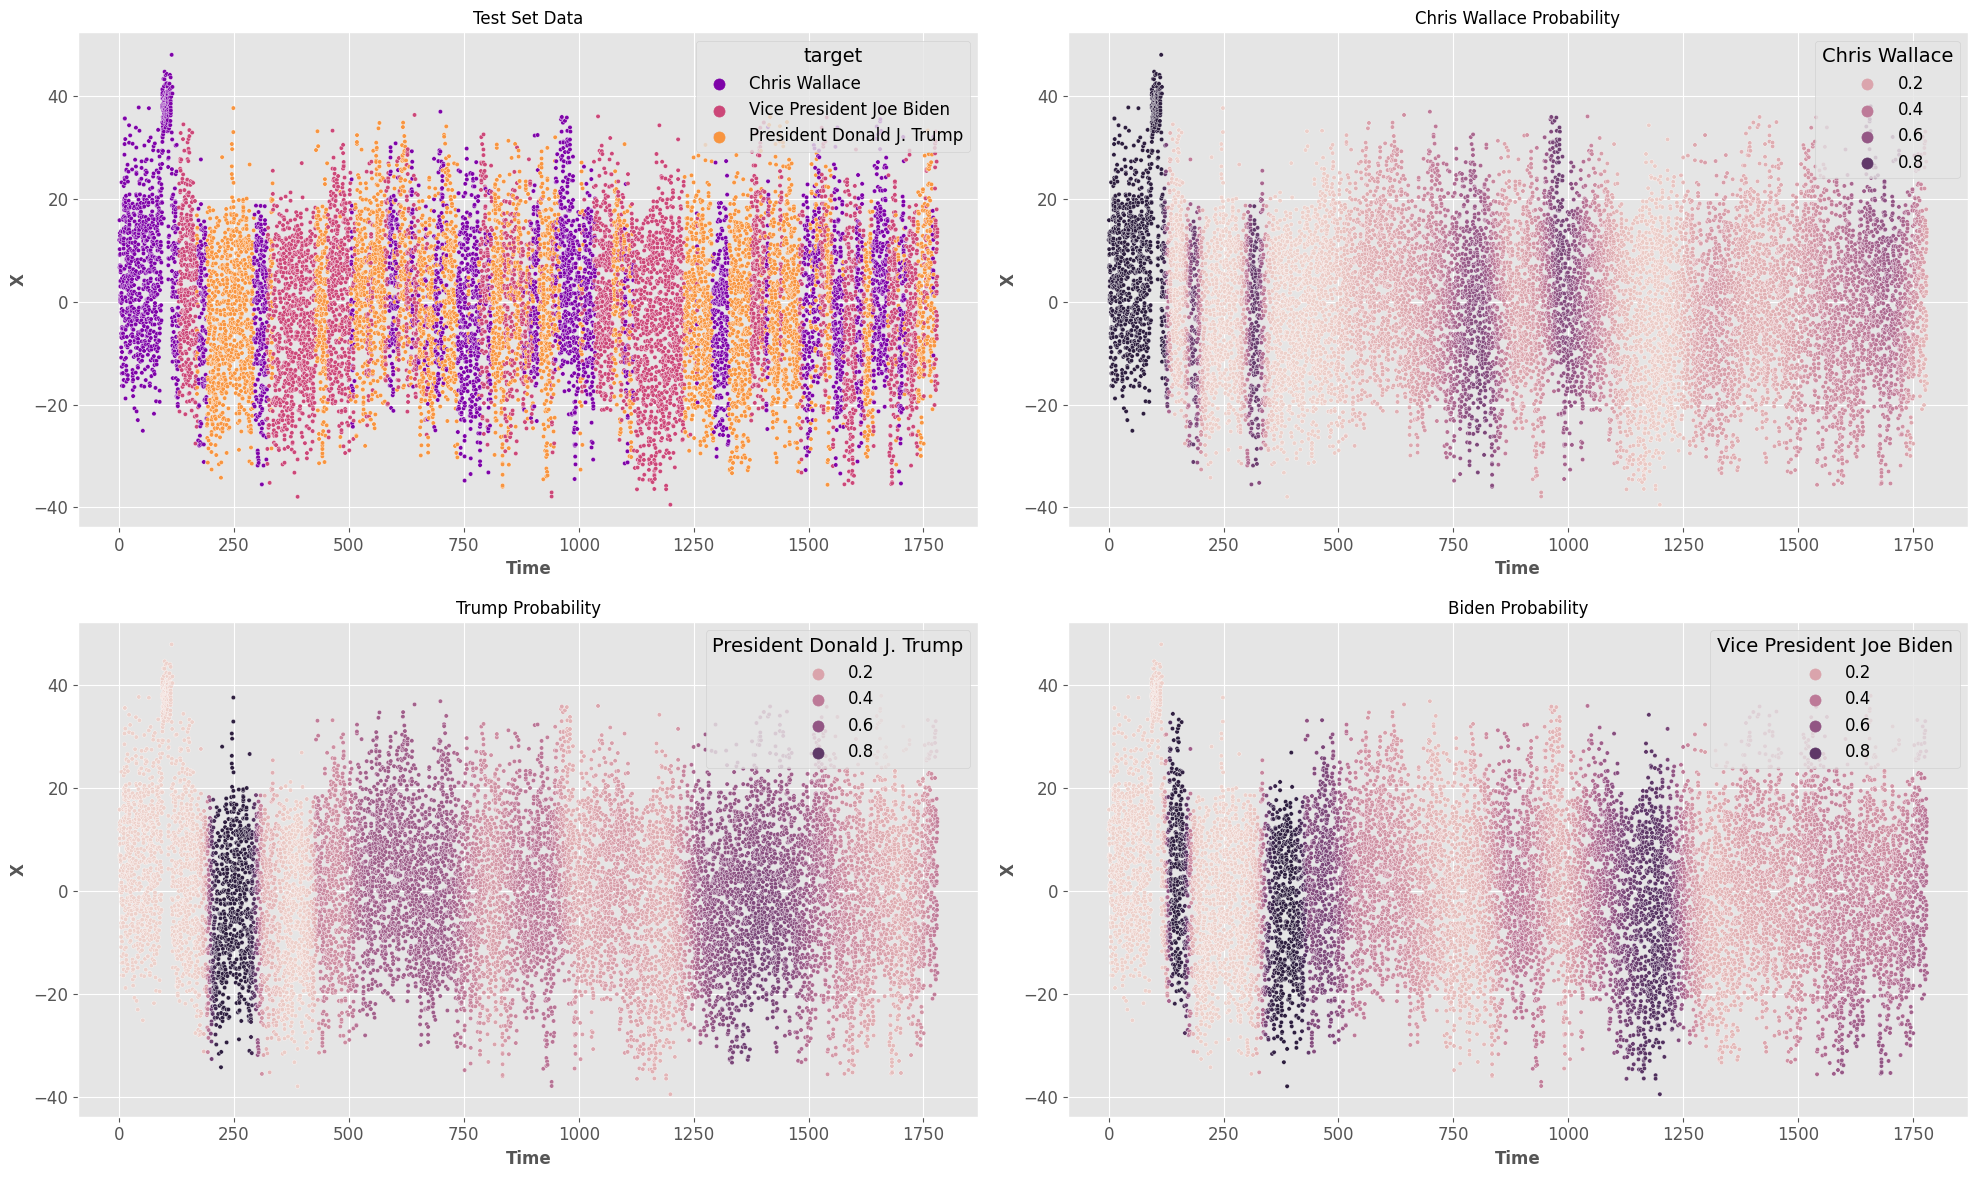

In [62]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title('Test Set Data')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data.target,palette='plasma')
plt.grid(True)
plt.subplot(2,2,2)
plt.title('Chris Wallace Probability')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data['Chris Wallace'])
plt.grid(True)
plt.subplot(2,2,3)
plt.title('Trump Probability')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data['President Donald J. Trump'])
plt.grid(True)
plt.subplot(2,2,4)
plt.title('Biden Probability')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data['Vice President Joe Biden'])
plt.grid(True)
plt.tight_layout()

In [63]:
def model_to_clf(input_data):
    pred_list = model.predict(input_data)
    LIST_PRED = []
    for p in pred_list:
        LIST_PRED.append(np.argmax(p))
    return LIST_PRED

In [64]:
cm=confusion_matrix(model_to_clf(x_test),y_test)
cm_data = pd.DataFrame(cm,columns=[encod_dic[0],encod_dic[1],encod_dic[2]])
cm_data.index = [encod_dic[0],encod_dic[1],encod_dic[2]]
cm_data

485/485 [==============================] - 1s 2ms/step


Chris Wallace  President Donald J. Trump  \
Chris Wallace                       2882                        664   
President Donald J. Trump           1333                       3875   
Vice President Joe Biden             324                       1087   

                           Vice President Joe Biden  
Chris Wallace                                   927  
President Donald J. Trump                       960  
Vice President Joe Biden                       3452

(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, 'Chris Wallace'),
  Text(1.5, 0, 'President Donald J. Trump'),
  Text(2.5, 0, 'Vice President Joe Biden')])

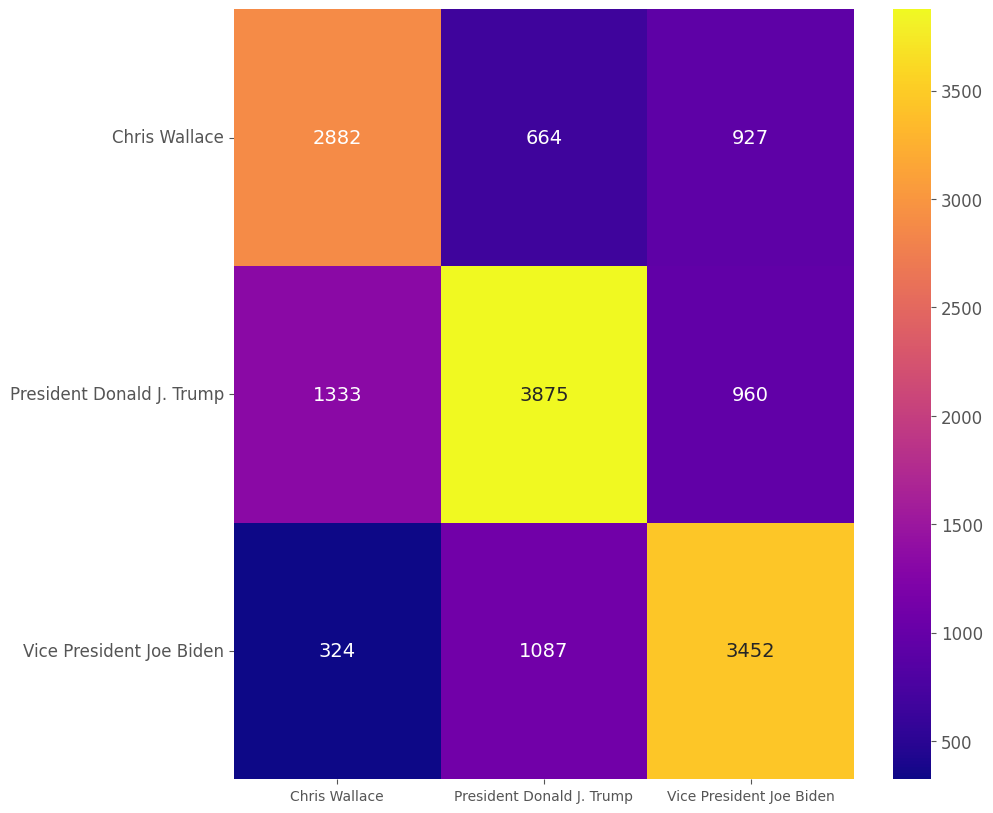

In [65]:
sns.heatmap(cm_data.astype(int), fmt='d', annot=True,cmap='plasma')
plt.yticks(rotation=0)
plt.xticks(rotation=0,fontsize=10)

485/485 [==============================] - 1s 2ms/step


<AxesSubplot:>

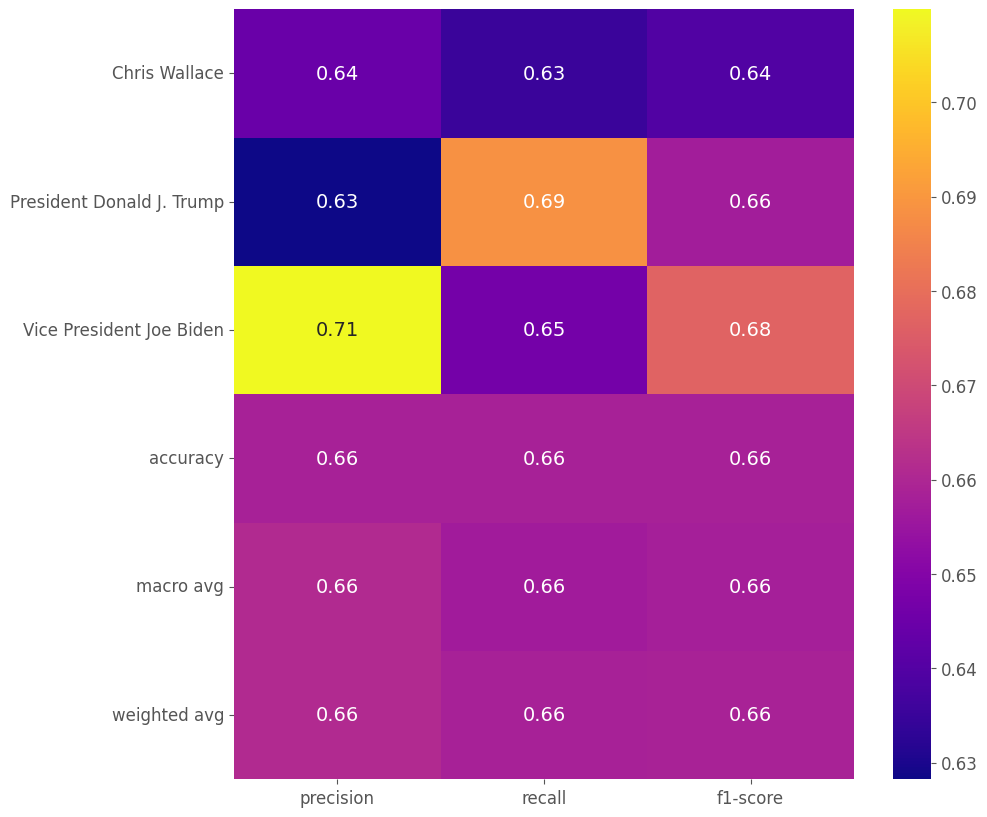

In [66]:
clf_report = classification_report(y_test,
                                   model_to_clf(x_test),
                                   labels= [0,1,2],
                                   target_names= [encod_dic[0],encod_dic[1],encod_dic[2]],
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='plasma')